# Align timelapses to center tissue mask centroids

* Author: Audrey Williams
* Created: 2022-08-08
* Status: Complete

Align timelapses using centroids of egg chamber masks to correct for tissue drift. Finds centroid coords in each frame with regionprops, centers image on them with Seth's `center_im` function. 

In [2]:
import numpy as np
from imageio import volread, volwrite
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.measure import label, regionprops

sys.path.append('../code/')
from functions.utils import center_im, select_files 

In [12]:
# Import movies
DATA_DIR = "/Users/sierraschwabach/Documents/kms/newtjabi/"
KEYS = [".tif", "_tracked.tif", "_tissue_mask.tif"]
OUT_KEYS = ["_reg", "_tracked", "_tissue_mask"]

datasets = select_files(DATA_DIR, KEYS)


# Try on 1 dataset

## Import

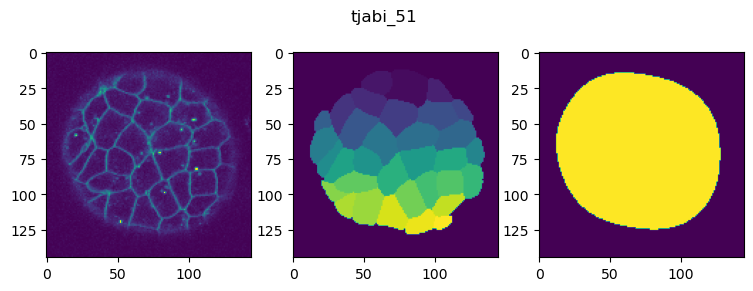

In [13]:
dataset = datasets[0]
basename = dataset["basename"]
ims = volread(dataset[".tif"])
ims_tracked = volread(dataset["_tracked.tif"])
tissue_masks = volread(dataset["_tissue_mask.tif"])



fig, axs = plt.subplots(1,3, figsize=(9,3))
fig.suptitle(f"{basename}")
axs[0].imshow(ims[0])
axs[1].imshow(ims_tracked[0])
axs[2].imshow(tissue_masks[0])


## Find tissue mask centroid coords, slide image in r and c so they're always centered
Note: Centroid coords rounded to nearest integer for centroid sliding, which creates jitter in otherwise drift-free movies. 

In [14]:
centroid_ls = []
tissue_masks_centered = np.zeros_like(tissue_masks)
for i, mask in enumerate(tissue_masks):
    mask_props = regionprops(label(mask))[0]
    centroid = mask_props["centroid"]
    centroid_ls.append(centroid)
    tissue_mask_centered = center_im(mask, centroid)
    tissue_masks_centered[i] = tissue_mask_centered

## Center other timelapses using the tissue_mask centroid coords

In [15]:
def center_timelapse(ims, coord_ls):
    """
    ims: 3D array
    coord_ls: list of tuples with same length as first index of ims
    ims_centered = 3D array with same shape as ims, with each frame shifted to center
        the equivalent coordinate in coord_ls
    """
    ims_centered = np.zeros_like(ims)
    for i, im in enumerate(ims):
        ims_centered[i] = center_im(im, coord_ls[i])
    return(ims_centered)

In [16]:
ims_centered = center_timelapse(ims, centroid_ls)
ims_tracked_centered = center_timelapse(ims_tracked, centroid_ls)

## Align all datasets, output

In [18]:
for dataset in datasets:
    basename = dataset["basename"]
    ims = volread(dataset[".tif"])
    ims_tracked = volread(dataset["_tracked.tif"])
    tissue_masks = volread(dataset["_tissue_mask.tif"])
    
    # Find tissue centroid coords in each frame,
    # align timelapse so these are at image center
    centroid_ls = []
    tissue_masks_centered = np.zeros_like(tissue_masks)
    for i, mask in enumerate(tissue_masks):
        mask_props = regionprops(label(mask))[0]
        centroid = mask_props["centroid"]
        centroid_ls.append(centroid)
        tissue_mask_centered = center_im(mask, centroid)
        tissue_masks_centered[i] = tissue_mask_centered
    
    # Align the intensities and tracked timelapses to the same coords
    ims_centered = center_timelapse(ims, centroid_ls)
    ims_tracked_centered = center_timelapse(ims_tracked, centroid_ls)
    
    # Output as tif
    ims_out_path = DATA_DIR + basename + OUT_KEYS[0] + ".tif"
    ims_tracked_out_path = DATA_DIR + basename + OUT_KEYS[1] + ".tif"
    tissue_masks_out_path = DATA_DIR + basename + OUT_KEYS[2] + ".tif"
    volwrite(ims_out_path, ims_centered)
    volwrite(ims_tracked_out_path, ims_tracked_centered)
    volwrite(tissue_masks_out_path, tissue_masks_centered)